## Assignment 1-Part 2
By Group 4: Qianjing Liang, Elouise Matthews, Naman Ratra, Luis Sejas

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from numpy import cov
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
import sympy as sympy
from scipy import *
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math, Latex
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

plt.rcParams['lines.markersize'] = 3

### Preparations:

#### (1) A function to prepare data for PCA analysis:

In [2]:
def prepare_data(dataframe):
    '''
    Returns the splitted training and test data for predictors and the target 
    variable, and standardize them.
    
    Note: this function is only applicable for dataframes with four columns, 
    with the three of them being the preictors under the names "x", "y", 
    and "z", and the fourth one being the target label under the name "label".
    '''
    
    # Read out samples (X) and labels (y)  
    X, y = dataframe[['x','y','z']].values, dataframe['label'].values

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=0)

    # Standardize the features (zero mean, unit variance)
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train) 
    # Normalize test data set with mu/sigma of training data
    X_test_std = sc.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X_train_std, X_test_std

#### (2) A function to calculate the explained variances of each predictor and the eigenvalue-eigenvector pairs:

In [3]:
def explained_variances(X_train_std):
    '''
    Returns the list of explained variances of each predictor of the dataset
    as well as the sorted eigenvalue-eigenvector pairs using standardized
    training data.
    '''
    # Compute covariance matrix and eigenvalues (EVal) / 
    # eigenvectors (EVec)
    cov_mat = np.cov(X_train_std.T) #cov matrix from data
    EVal, EVec = np.linalg.eig(cov_mat)

    # Calculate (sum of) explained variances
    sum_EVal = np.sum(EVal)
    var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

    # Make a list of (eigenvalue, eigenvector) tuples
    eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i \
                   in range(len(EVal))]

    # Sort the (EVal, EVec) tuples from high to low (reverse),
    # key=EV
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)
    
    return var_exp, eigen_pairs

#### (3) A function to plot the (sorted) explained variances of each predictor in a bar graph:

In [4]:
def plot_explained_var(ax, var_exp):
    ax.bar(range(1,4), var_exp, alpha=0.3, align='center',
           label='individual, explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index') # rank of PC
    ax.legend(loc='best')

#### (4) A function to plot the PCA-transformed data and decision boundaries after applying a classifier model:

In [5]:
def plot_with_decision_regions(ax, X, y, classifier, 
                               num_class, resolution=0.01):
    '''
    Returns a graph of the pca-transformed data as well as decision boundaries
    after applying a classifier model.
    
    Note: this function only works with classification models that have less
    than or equal to 4 classes.
    '''
    markers = ('s', 'v', 'o', '*') 
    colors = ('r', 'b', 'g', 'm')
    markers = markers[:num_class]
    colors = colors[:num_class]
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Z is the prediction of the class, given point in plane
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Z=f(xx1,yy1), plot classes in plane using color map but opaque
    ax.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    # Plot data points, given labels
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(loc='lower left')

### $\textbf{Question (a)}$

#### (a-1) Generate datasets of clearly separable and overlapping blobs:
To make the four clearly separable/messy blobs, the multivariate Gaussian distribution generator package is used here

In [6]:
# Set up the mean values of the multivariate Gaussian distribution for the 
# four clearly separable blobs
mu_1 = np.array([-5.25, 4.75])
mu_2 = np.array([-5.25, -4.75])
mu_3 = np.array([5.25, 4.75])
mu_4 = np.array([5.25, -4.75])
sigma_1 = np.array([[1.75, 0], [0, 1.5]])

# Number of data points in each blob
datapoint = 500

In [7]:
mu_clean = [mu_1, mu_2, mu_3, mu_4]
blob_clean = []

for i in range(4):
    mu = mu_clean[i]
    # Generate x and y from multivariate Gaussian distribution using the 
    # mean values defined above
    x, y = np.random.multivariate_normal(mu, sigma_1, datapoint).T
    data = pd.concat([pd.DataFrame(x, columns=['x']), 
                      pd.DataFrame(y, columns=['y'])], axis=1)
    data['z'] = 0 # initialize the third dimension
    data['label'] = i+1 # assign labels
    blob_clean.append(data)

blobs_clean = pd.concat([blob_clean[0],blob_clean[1],
                         blob_clean[2],blob_clean[3]])
blobs_clean['z'] = 0.5*(blobs_clean.x) + blobs_clean.y

In [8]:
del x, y, data
# Adjust the mean values of the clean blobs to make them closer to 
# each other, therefore resulting in blobs that have more 
# overlapping with each other
mu_messy = [mu_1*0.2, mu_2*0.25, mu_3*0.25, mu_4*0.2]
blob_messy = []

for i in range(4):
    mu = mu_messy[i]
    # Generate x and y from multivariate Gaussian distribution using the
    # mean values defined above
    x, y = np.random.multivariate_normal(mu, sigma_1, datapoint).T
    data = pd.concat([pd.DataFrame(x, columns=['x']), 
                      pd.DataFrame(y, columns=['y'])], axis=1)
    data['z'] = 0 # initialize the third dimension
    data['label'] = i+1 #assign labels
    blob_messy.append(data)

blobs_messy = pd.concat([blob_messy[0],blob_messy[1],
                         blob_messy[2],blob_messy[3]])
blobs_messy['z'] = 0.5*(blobs_messy.x) + blobs_messy.y

#### (a-2) Visualizing the clearly separable and overlapping blobs (2D)

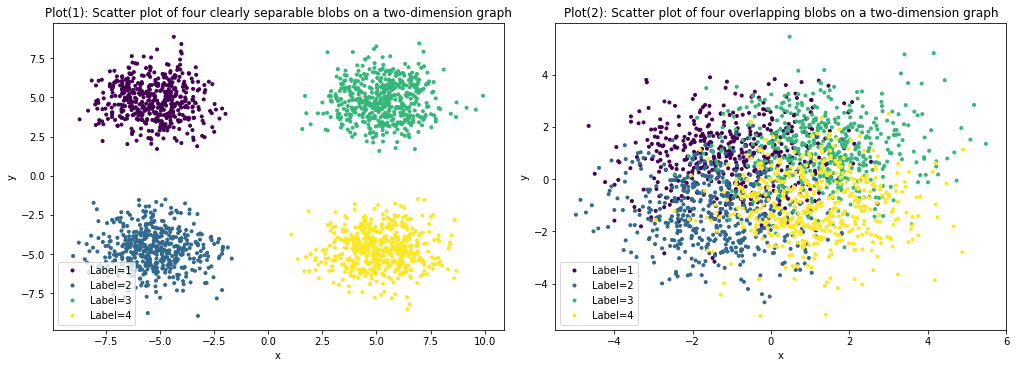

In [9]:
fig1, ax1 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
classes = ['Label=1','Label=2','Label=3','Label=4']

# Visualize the first case with four clearly separable blobs 
# on 2D graph
scatter = ax1[0].scatter(blobs_clean['x'], blobs_clean['y'], 
                         c=blobs_clean['label'])
ax1[0].set_title("Plot(1): Scatter plot of four clearly separable "+\
                 "blobs on a two-dimension graph")

# Visualize the second case with four overlapping blobs 
# on 2D graph
scatter2 = ax1[1].scatter(blobs_messy['x'], blobs_messy['y'], 
                          c=blobs_messy['label'])
ax1[1].set_title("Plot(2): Scatter plot of four overlapping "+\
                 "blobs on a two-dimension graph")

for i in range(2):
    ax1[i].legend(handles=scatter.legend_elements()[0], 
                  labels=classes, loc='lower left')
    ax1[i].set_xlabel('x')
    ax1[i].set_ylabel('y')

#### Observations of (a-2):
Plot(1) shows the clearly separable blobs on a 2D graph with relatively wide gaps among them. \
Plot(2) shows the overlapping blobs on a 2D graph--the four blobs now have much more overlapping with each other compared to Plot(1).

#### (a-3) Visualizing the clearly separable and overlapping blobs (3D)

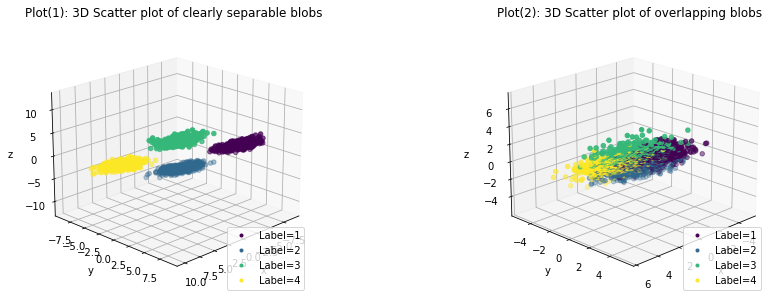

In [10]:
fig2 = plt.figure(figsize=(15,5))

# Visualize the first case with four clearly separable blobs 
# in 3 dimensions
ax2 = fig2.add_subplot(1, 2, 1, projection='3d')
scatter3 = ax2.scatter3D(blobs_clean['x'], blobs_clean['y'], 
                         blobs_clean['z'], c=blobs_clean['label'])
ax2.set_title('Plot(1): 3D Scatter plot of clearly separable blobs')

# Visualize the second case with four overlapping blobs in 3 dimensions
ax3 = fig2.add_subplot(1, 2, 2, projection='3d')
scatter4 = ax3.scatter3D(blobs_messy['x'], blobs_messy['y'], 
                         blobs_messy['z'], c=blobs_messy['label'])
ax3.set_title('Plot(2): 3D Scatter plot of overlapping blobs')

for ax in [ax2, ax3]:    
    ax.view_init(20, 45)
    ax.legend(handles=scatter3.legend_elements()[0], 
              labels=classes, loc='lower right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

#### Observations of (a-3):
Plot(1) shows the clearly separable blobs in 3D, which are distributed on a tilted plane; the third dimension ("z") of the blobs do not apppear to contribute to the labels of the data points.

Plot(2) shows the overlapping blobs in 3D, which are distributed on a tilted plane; the third dimension ("z") of the blobs do not apppear to contribute to the labels of the data points.

#### (a-4) Use PCA analysis and class prediction (using logistic regression classifier) on both cases

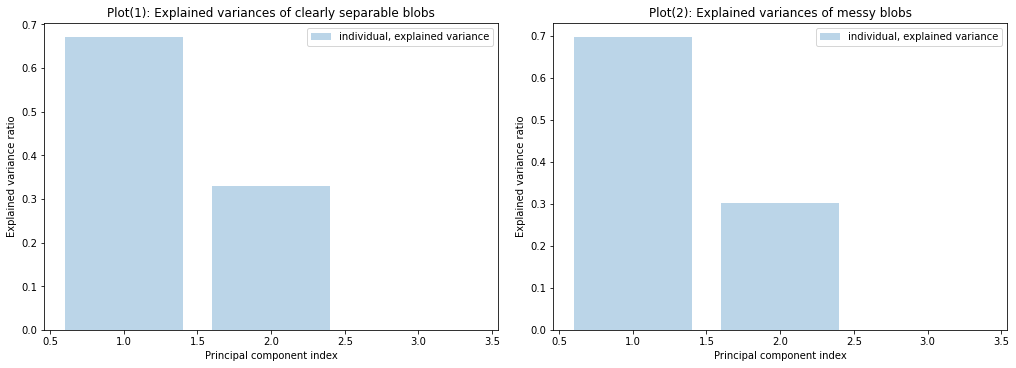

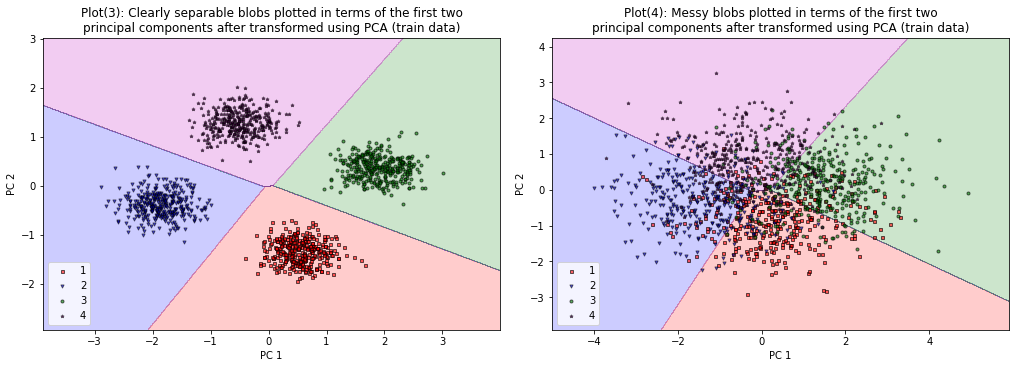

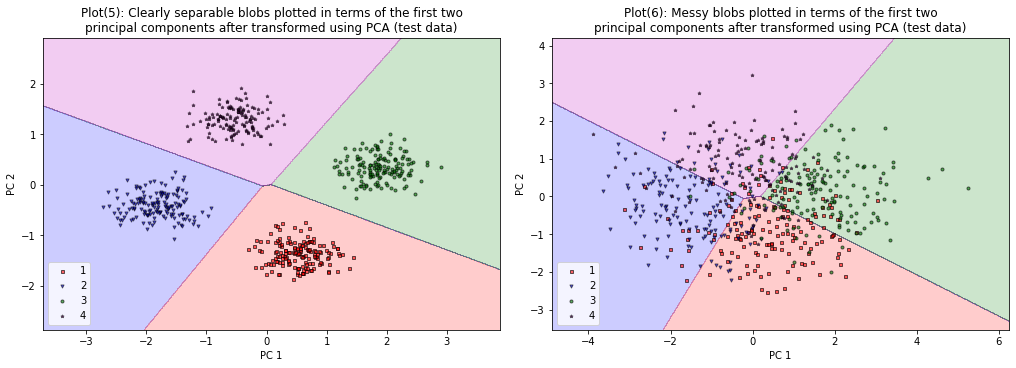

In [11]:
blobs = [blobs_clean, blobs_messy]

# Preparation of graphs
fig3, ax4 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
fig4, ax5 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
fig5, ax6 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)

ax4[0].set_title("Plot(1): Explained variances of clearly separable "+\
                 "blobs")
ax4[1].set_title("Plot(2): Explained variances of messy blobs")
ax5[0].set_title("Plot(3): Clearly separable blobs plotted in terms "+\
                 "of the first two\nprincipal components after " +\
                 "transformed using PCA (train data)")
ax5[1].set_title("Plot(4): Messy blobs plotted in terms of the " + \
                 "first two\nprincipal components after "+\
                 "transformed using PCA (train data)")
ax6[0].set_title("Plot(5): Clearly separable blobs plotted in terms " +\
                 "of the first two\nprincipal components after "+\
                 "transformed using PCA (test data)")
ax6[1].set_title("Plot(6): Messy blobs plotted in terms of the " +\
                 "first two\nprincipal components after "+\
                 "transformed using PCA (test data)")

for i in range(2):
    blob = blobs[i]
    # Split and transform data
    X_train,X_test,y_train,y_test,X_train_std,X_test_std=prepare_data(blob)
    
    # Calculate explained variances and eigenvalue-eigenvector pairs
    var_exp, eigen_pairs = explained_variances(X_train_std)
    
    # Elbow plot
    plot_explained_var(ax4[i], var_exp)
    
    # Set up PCA and logistic regression model
    pca = PCA(n_components=2)
    lr = LogisticRegression(multi_class='ovr', solver='liblinear')

    # Fit and transform training and test data, given PCA reduction to 
    # 2 principle components
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    
    # solve task given 4 classes and plot transformed data with 
    # decision boundaries
    lr.fit(X_train_pca, y_train) 
    plot_with_decision_regions(ax5[i], X_train_pca, y_train, 
                               lr, num_class=4)
    plot_with_decision_regions(ax6[i], X_test_pca, y_test, 
                               lr, num_class=4)

#### Analysis of (a-4):
Plot(1) shows that in the case of clearly separable blobs, the first two principal components of the PCA analysis are able to explain almost all the variances of the data.

Plot(2) shows that similar to Plot (1), in the case of overlapping blobs, the first two principal components of the PCA analysis are able to explain almost all the variances of the data.

Plot(3) shows that the logistic regression model's decision boundaries clearly separated the four clearly separable blobs, and the gaps among different classes are relatively wide.

Plot(4) shows that the logistic regression model's decision boundaries are much less effective in the case of overlapping blobs, as the points near the boundaries are much more concentrated compared to Plot(3), and the gaps among different classes are much narrower.

Plot(5) shows a phenomenon similar to that in Plot(3): the classfier was effective in the case of four clearly separable blobs.

Plot(6) shows a phenomenon similar to that in Plot(4): the classifier showed a much lower accuracy in the case of overlapping blobs.


Plots (1) and (2) show the ranked explained variances of each predictor after using PCA analysis on the clearly separable and messy blobs. They show that in both cases, PCA managed to distinguish between the two important variables (likely the "x" and "y" in this notebook) and the third variable that doesn't contribute as much to the data complexity (likely the "z" in this notebook which is intended to be meaningless).

Plots(3)-(6), in comparison, shows more differences between the two cases. In the first case where blobs are clearly separable, the decision boundaries are much more effective in differenciating between different classes and the gaps among different classes are much higher (as shown in Plots (3) and (5)). Meanwhile, even though the PCA analysis in the second case is able to distinguish between the important variables and the others, Plots (4) and (6) show that when blobs have strong overlappings, the decision boundaries can only differenciate part of the data points with the rest, while the gaps among different classes have become much narrower.

### $\textbf{Question (b)}$

In [12]:
del x, y, data
del X_train, X_test, y_train, y_test, X_train_std, X_test_std
del var_exp, eigen_pairs
del X_train_pca, X_test_pca

#### (b-1) Generate datasets of touching and overlapping parabolas

In [13]:
# Generate data points of two touching parabolas
para_clean = []

x = np.linspace(-10,10,1000)
eq = x ** 2 + 10
y_s = [np.random.normal(eq, 6), np.random.normal(-eq, 6)]

for i in range(2):
    y = y_s[i]
    data = pd.concat([pd.DataFrame(x, columns=['x']), 
                      pd.DataFrame(y, columns=['y'])], axis=1)
    data['z'] = 0 # initialize the third dimension
    data['label'] = i+1 # assign labels
    para_clean.append(data)

para_clean = pd.concat([para_clean[0],para_clean[1]])
para_clean['z'] = (para_clean.x)*0.5 + para_clean.y

In [14]:
# Generate data points of two strongly overlapping parabolas
para_messy = []
eq2 = x ** 2 - 22
y_s2 = [np.random.normal(eq2, 6), np.random.normal(-eq2, 6)]

for i in range(2):
    y = y_s2[i]
    data = pd.concat([pd.DataFrame(x, columns=['x']), 
                      pd.DataFrame(y, columns=['y'])], axis=1)
    data['z'] = 0 # initialize the third dimension
    data['label'] = i+1 # assign labels
    para_messy.append(data)

para_messy = pd.concat([para_messy[0],para_messy[1]])
para_messy['z'] = (para_messy.x)*0.5 + para_messy.y

#### (b-2) Visualizing the touching and overlapping parabolas (2D)

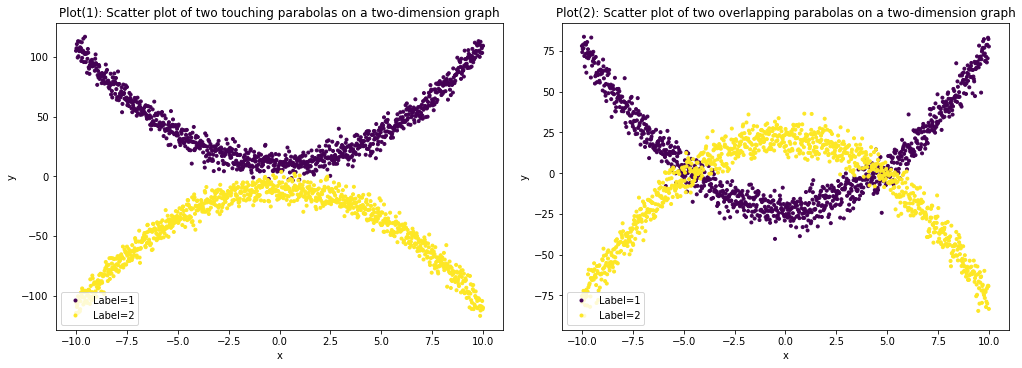

In [15]:
fig6, ax7 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
classes2 = ['Label=1','Label=2']

scatter5 = ax7[0].scatter(para_clean['x'], para_clean['y'], 
                          c=para_clean['label'])
ax7[0].set_title("Plot(1): Scatter plot of two touching parabolas "+\
                 "on a two-dimension graph")

scatter6 = ax7[1].scatter(para_messy['x'], para_messy['y'], 
                          c=para_messy['label'])
ax7[1].set_title("Plot(2): Scatter plot of two overlapping parabolas "+\
                 "on a two-dimension graph")

for i in range(2):
    ax7[i].legend(handles=scatter5.legend_elements()[0], 
                  labels=classes2, loc='lower left')
    ax7[i].set_xlabel('x')
    ax7[i].set_ylabel('y')

#### Observations of (b-2):
Plot(1) shows the touching parabolas on a 2D graph--as the two curves are barely touching, the boundaries of both parabolas only have a very small area of overlapping. \
Plot(2) shows the overlapping parabolas on a 2D graph--the two curves now have much more overlapping with each other compared to Plot(1).

#### (b-3) Visualizing the touching and overlapping parabolas (3D)

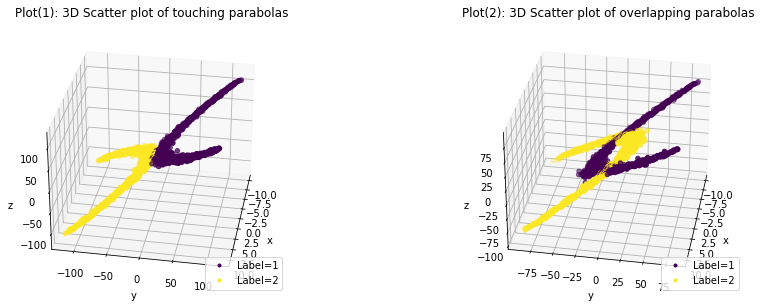

In [16]:
fig7 = plt.figure(figsize=(15,5))

# Visualize the first case with two touching parabolas in 
# 3 dimensions
ax8 = fig7.add_subplot(1, 2, 1, projection='3d')
scatter7 = ax8.scatter3D(para_clean['x'], para_clean['y'], 
                         para_clean['z'], c=para_clean['label'])
ax8.set_title('Plot(1): 3D Scatter plot of touching parabolas')

# Visualize the second case with four overlapping parabolas in 
# 3 dimensions
ax9 = fig7.add_subplot(1, 2, 2, projection='3d')
scatter8 = ax9.scatter3D(para_messy['x'], para_messy['y'], 
                         para_messy['z'], c=para_messy['label'])
ax9.set_title('Plot(2): 3D Scatter plot of overlapping parabolas')

for ax in [ax8, ax9]:
    ax.view_init(30, 10)
    ax.legend(handles=scatter7.legend_elements()[0], 
              labels=classes2, loc='lower right')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

#### Observations of (b-3):
Plot(1) shows the touching parabolas in 3D, both of which lie on the same plane, and the third dimension ("z") of both parabolas don't seem to contribute to the labels of the data points.

Plot(2) shows the overlapping parabolas in 3D, both of which lie on the same plane, and the third dimension ("z") of both parabolas don't seem to contribute to the labels of the data points.

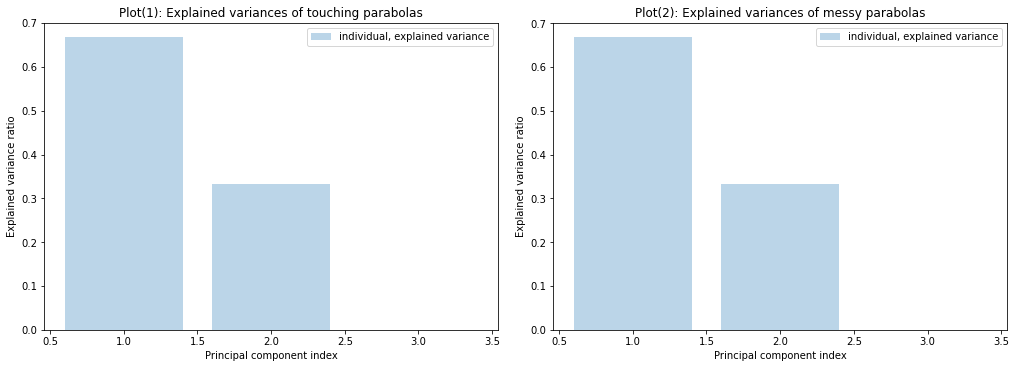

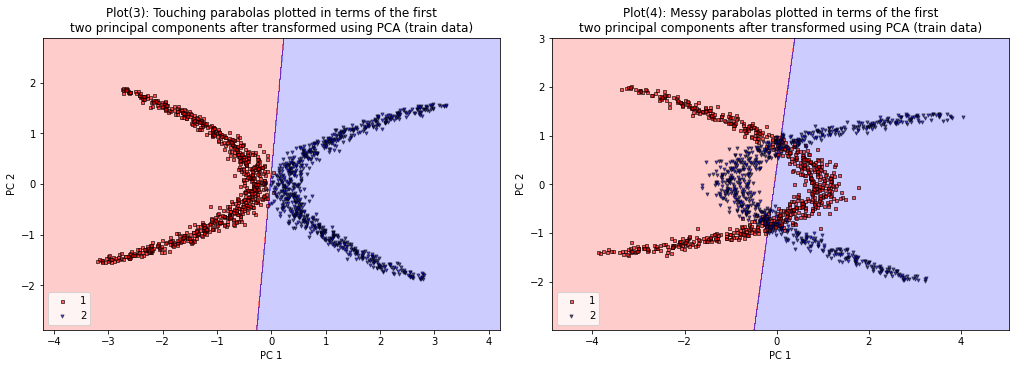

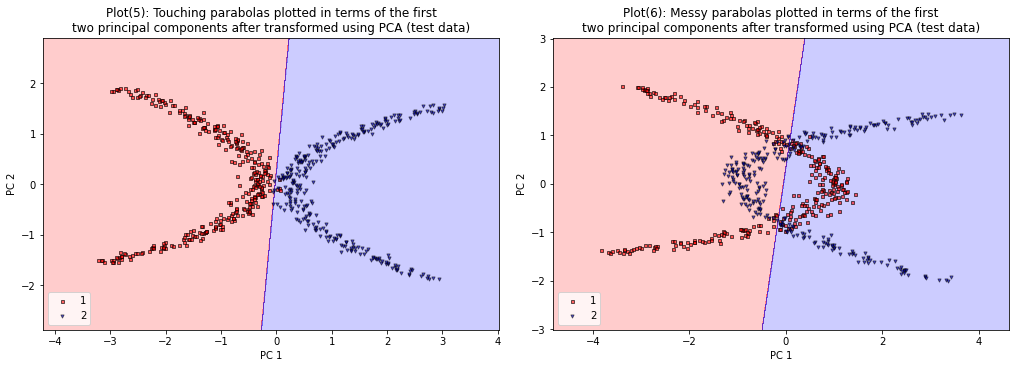

In [17]:
paras = [para_clean, para_messy]

# Preparation of graphs
fig7, ax8 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
fig8, ax9 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
fig9, ax10 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)

ax8[0].set_title("Plot(1): Explained variances of touching parabolas")
ax8[1].set_title("Plot(2): Explained variances of messy parabolas")
ax9[0].set_title("Plot(3): Touching parabolas plotted in terms " + \
                 "of the first\ntwo principal components after "+\
                 "transformed using PCA (train data)")
ax9[1].set_title("Plot(4): Messy parabolas plotted in terms of " + \
                 "the first\ntwo principal components after "+\
                 "transformed using PCA (train data)")
ax10[0].set_title("Plot(5): Touching parabolas plotted in terms " +\
                  "of the first\ntwo principal components after "+\
                  "transformed using PCA (test data)")
ax10[1].set_title("Plot(6): Messy parabolas plotted in terms " +\
                  "of the first\ntwo principal components after "+\
                  "transformed using PCA (test data)")

for i in range(2):
    parabola = paras[i]
    # Split and transform data
    X_train,X_test,y_train,y_test,X_train_std,X_test_std=prepare_data(parabola)
    
    # Calculate eigenvalues explained variances
    var_exp, eigen_pairs = explained_variances(X_train_std)

    # Elbow plot
    plot_explained_var(ax8[i], var_exp)
    
    # Set up PCA and logistic regression model
    pca2 = PCA(n_components=2)
    lr2 = LogisticRegression(solver='liblinear')

    # Fit and transform training data, given on PCA reduction to 
    # 2 principle components
    X_train_pca = pca2.fit_transform(X_train_std)
    X_test_pca = pca2.transform(X_test_std)
    
    # solves task, given 2 classes (as from y_train) 
    lr2.fit(X_train_pca, y_train) 
    plot_with_decision_regions(ax9[i], X_train_pca, y_train, 
                               lr2, num_class=2)
    plot_with_decision_regions(ax10[i], X_test_pca, y_test, 
                               lr2, num_class=2)

#### Analysis of (b-4):
Plot(1) shows that in the case of two touching parabolas, the first two principal components of the PCA analysis are able to explain almost all the variances of the data.

Plot(2) shows that similar to Plot (1), in the case of overlapping parabolas, the first two principal components of the PCA analysis are able to explain almost all the variances of the data.

Plot(3) shows that the logistic regression model's decision boundaries clearly separated the touching parabolas.

Plot(4) shows that while the logistic regression model's decision boundary generally separated the two classes of the overlapping parabolas, the points near the boundary are much more concentrated compared to Plot(3), suggesting that the classifier was less effective.

Plot(5) shows a phenomenon similar to that in Plot(3): the logistic regression model's decision boundaries clearly separated the touching parabolas.

Plot(6) shows a phenomenon similar to that in Plot(4): the classifier for the overlapping parabolas was less effective than the one for the touching parabolas.


Plots (1) and (2) show the ranked explained variances of each predictor after using PCA analysis on the touching and overlapping parabolas. They show that in both cases, PCA managed to distinguish between the two important variables (likely the "x" and "y" in this notebook) and the third variable that doesn't contribute as much to the data complexity (likely the "z" in this notebook which is intended to be meaningless).

Plots(3)-(6), in comparison, shows more differences between the two cases. In the first case where the parabolas are touching, the decision boundary was much more effective in differenciating between different classes (as shown in Plots (3) and (5)). Meanwhile, even though the PCA analysis in the second case was able to distinguish between the important variables and the others, Plots (4) and (6) show that when parabolas have strong overlappings, the decision boundaries can only differenciate part of the data points with the rest.

### Overall observations:
The two situations presented in (a) and (b) show that:
While PCA analysis can help differentiate the relatively more important variables, classifier models (at least for logistic regression models as shown here) might still have difficulty in correctly assigning labels when there are noise variables in the dataset. It is also not surprising to see that the classfier model was able to perform better when there are fewer overlappings among different classes.